In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C

In [2]:
np.random.seed(1)

# Applications of Gaussian Processes in Cosmology

## Reconstruction of Hubble Parameter and comparison with $\Lambda CDM$

In [3]:
# Hubble Parameter in LCDM model
def H_lcdm(o_m,o_k,o_l,z):
    return(73.2*np.sqrt((1-o_k-o_m-o_l)*(1+z)**4 + o_m*(1+z)**3 + o_k*(1+z)**2 + o_l))

In [4]:
# Reading and processing of data
data=pd.read_table("Hz_all.dat",sep="\s+")
data_arr=np.asarray(data)

Z=np.atleast_2d(np.array([float(i) for i in data_arr[1:,0]])).T
H=np.array([float(i) for i in data_arr[1:,1]])
dH=np.array([float(i) for i in data_arr[1:,2]])

In [5]:
# Values where the predictions will be made
z = np.atleast_2d(np.linspace(0, 2., 500)).T

# Estimation of the model
k =  C(1.0) * Matern()
gp = GaussianProcessRegressor(kernel=k,alpha=dH ** 2,n_restarts_optimizer=10)

gp.fit(Z, H)

H_pred, sigma_H = gp.predict(z, return_std=True)

In [6]:
# Graph
def graph(f,sigma,x,y,dy,xs):
    plt.scatter(x,y,color="black",s=12,label=u'Data')
    plt.errorbar(x.ravel(), y, dy,linestyle="None", elinewidth=1,
            color="black")
    plt.plot(xs, f, label=u'Model',color="midnightblue")
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f - 1.96*sigma,
                        (f + 1.96*sigma)[::-1]]), color="blueviolet",
         alpha=.35, ec='None')
    plt.fill(np.concatenate([xs, xs[::-1]]),
         np.concatenate([f - 2.576 * sigma,
                        (f + 2.576 * sigma)[::-1]]), color="blue",
         alpha=.15, ec='None')
    plt.legend(loc='best')
    plt.grid(alpha=0.6)
    plt.xlim(0,2)

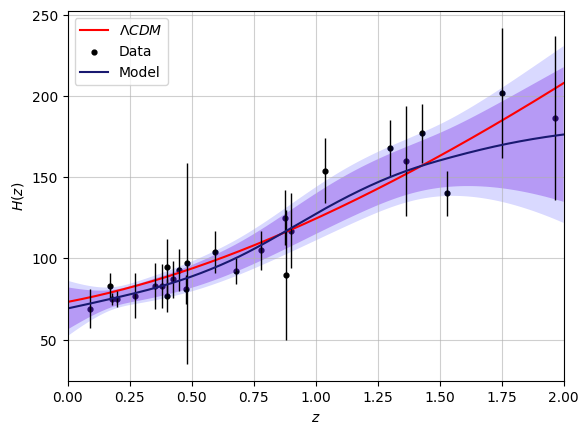

In [7]:
# LambdaCDM model
Hlcdm=np.array([H_lcdm(0.266,0,0.732,i) for i in z])
plt.plot(z,Hlcdm,color="red",label="$\Lambda CDM$")

# GP model
graph(H_pred,sigma_H,Z,H,dH,z)

plt.xlabel('$z$')
plt.ylabel('$H(z)$')
plt.savefig("Modelo_GP_Hubble_lcdm");

$$
\textbf{Comoving distance.}
$$
Due to the homogeneity of the Universe, it is possible to define a coordinate system that considers the Universe expansion. The distance between two objects in this system remains constant, so the comoving distance is defined as:
$$
        d_{C}(z)=d_{H}\int_{0}^{z}{dz'\frac{H_{0}}{H(z')}}
$$
$$
\textbf{Transverse comoving distance.}
$$
When considering the curvature intrinsic to the geometry of space-time, expressed by the parameter $\Omega_k$, the transversal comoving distance is defined as:
$$
        d_{M}=\begin{cases}\frac{d_{H}}{\sqrt{\Omega_{k}}}\sinh{\left(\frac{\sqrt{\Omega_{k}}d_{C}(z)}{d_{H}}\right)}&\text{ if }\Omega_{k}>0\\
        d_{C}(z)&\text{ if }\Omega_{k}=0\\
        \frac{d_{H}}{\sqrt{-\Omega_{k}}}\sinh{\left(\frac{\sqrt{-\Omega_{k}}d_{C}(z)}{d_{H}}\right)}&\text{ if }\Omega_{k}<0
        \end{cases}
$$
which is equal to the comoving distance in the case of a flat space-time, for $\Omega_k=0$.
$$
\textbf{Luminosity distance.}
$$
   Comparing the absolute and apparent magnitudes between two objects, that is, the actual brightness emitted by an object compared to the brightness observed from Earth, the luminosity distance is defined, which is written in terms of the transverse comoving distance as:
$$
        d_{L}(z)=(1+z)d_{M}(z)
$$
where the Hubble distance is defined as $d_{H}=\frac{c}{H_{0}}$.

From these equations, the normalized comoving distance is also obtained:
$$
    D(z)=\left(\frac{H_{0}}{c}\right)\left(\frac{1}{1+z}\right)d_{L(z)}
$$
As mentioned above, the value $\Omega_{k}=0$, represents the case of a flat Universe model. In this case, a simple expression for the derivative of the normalized comoving distance can be obtained:
$$
    D'(z)=\frac{H_{0}}{H(z)}
$$
On the other hand, the deceleration parameter is defined as:
$$
    q=-\frac{\ddot{a}a}{\dot{a}^{2}}
$$
which can be written in terms of the derivatives of $D(z)$ when $\Omega_{k}=0$ as:
$$
    q(z)=-\frac{D'(z)}{D''(z)}(1+z)-1
$$
This parameter is a dimensionless measure of the cosmic acceleration of the expansion of space.

## Reconstruction of $D'(z)$

In [8]:
# Hubble parameter and standard deviation at redshift 0
H_0=H_pred[0];sigma_H0=sigma_H[0]

# Derivative of the normalized comoving distance
Dz_prime=H_0/H

# Approximation of the standard deviation for a ratio distribution, 
# applicable in this case:
sigma_Dz_prime=np.array([np.sqrt((H_0**2/H[i]**2)*(sigma_H0**2/H_0**2 + dH[i]**2/H[i]**2)) 
                         for i in range(len(H))])

In [9]:
# Estimation of the model
gp = GaussianProcessRegressor(kernel=k,alpha=sigma_Dz_prime**2,n_restarts_optimizer=10)

gp.fit(Z, Dz_prime)

DzPrime_pred, sigma_DzPrime = gp.predict(z, return_std=True)

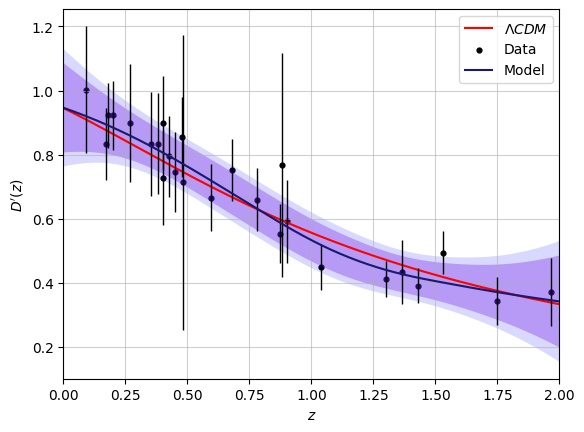

In [10]:
# LambdaCDM model
DzP_lcdm=np.array([H_0/H_lcdm(0.266,0,0.732,i) for i in z])
plt.plot(z,DzP_lcdm,color="red",label="$\Lambda CDM$")

# GP model
graph(DzPrime_pred,sigma_DzPrime,Z,Dz_prime,sigma_Dz_prime,z)

plt.xlabel("$z$")
plt.ylabel("$D'(z)$")
plt.savefig("D_p_lcdm");

## Reconstruction of $D''(z)$

In [11]:
import gapp

from gapp import gp
from gapp import dgp
from gapp import covariance

In [12]:
# Second derivative of D(z) in LCDM model 
def D_pp_lcdm(o_m,o_k,o_l,z):
    o_r=1-o_k-o_m-o_l
    return(-(1/2)*(4*o_r*(1+z)**3 + 3*o_m*(1+z)**2 + 2*o_k*(1+z))/((o_r*(1+z)**4 
                                + o_m*(1+z)**3 + o_k*(1+z)**2 + o_l)**(3/2)))

In [13]:
xmin = 0.0
xmax = 2.0
nstar = 100
initheta = [0.0,0.0]
g = dgp.DGaussianProcess(Z.ravel(), Dz_prime, sigma_Dz_prime, cXstar = (xmin, xmax, nstar))

(drec, theta) = g.dgp(thetatrain = 'False')

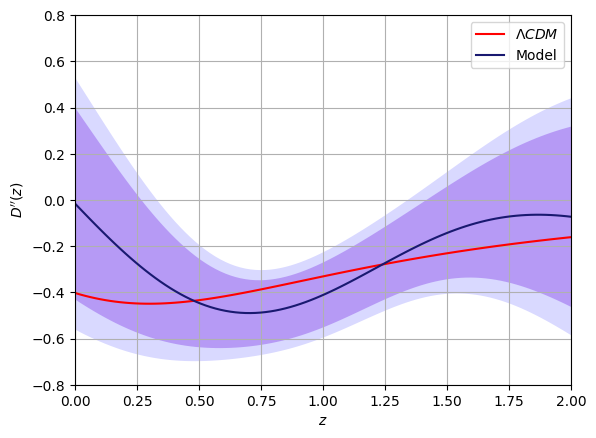

In [14]:
# LambdaCDM model
y_lcdm=np.array([D_pp_lcdm(0.266,0,0.732,i) for i in drec[:, 0]])
plt.plot(drec[:, 0],y_lcdm,color="red",label="$\Lambda CDM$")

# GP model
plt.plot(drec[:, 0], drec[:, 1], label=u"Model",color="midnightblue")
plt.fill_between(drec[:, 0], drec[:, 1] + 1.96*drec[:, 2], 
                     drec[:, 1] - 1.96*drec[:, 2], facecolor='blueviolet',alpha=0.35)
plt.fill_between(drec[:, 0], drec[:, 1] + 2.576*drec[:, 2], 
                     drec[:, 1] - 2.576*drec[:, 2], facecolor='blue',alpha=0.15)
plt.xlabel("$z$")
plt.ylabel("$D''(z)$")
plt.xlim(0, 2)
plt.ylim(-0.8,0.8)
plt.legend(loc='best')
plt.grid()
plt.savefig("Dpp_lcdm")

## Reconstruction of $q(z)$

In [15]:
# Evaluating the D''(z) model in the values of z in the data
zs=[float(i) for i in data_arr[1:,0]]

g = dgp.DGaussianProcess(Z.ravel(), Dz_prime, sigma_Dz_prime, Xstar = zs)

(drec, theta) = g.dgp(thetatrain = 'False')

D_pp=drec[:,1];sigma_Dpp=drec[:,2];
D_p=Dz_prime;sigma_Dp=sigma_Dz_prime;

In [16]:
zs=np.atleast_2d(np.array([float(i) for i in data_arr[1:,0]])).T;

q=np.array([-(D_pp[i]/D_p[i])*(1+zs[i][0])-1 for i in range(len(zs))])

sig_quot=np.array([np.sqrt(((D_pp[i]**2)/(D_p[i]**2))*((sigma_Dpp[i]**2)/(D_pp[i]**2) + 
                (sigma_Dp[i]**2)/(D_p[i]**2))) for i in range(len(D_p))])

sigma_q=np.array([sig_quot[i] + zs[i][0]*sig_quot[i] for i in range(len(sig_quot))])

In [17]:
gp = GaussianProcessRegressor(kernel=k,alpha=sigma_q**2,n_restarts_optimizer=10)

gp.fit(zs, q)

zx = np.atleast_2d(np.linspace(0, 2., 100)).T
q,sig_q=gp.predict(zx,return_std=True)

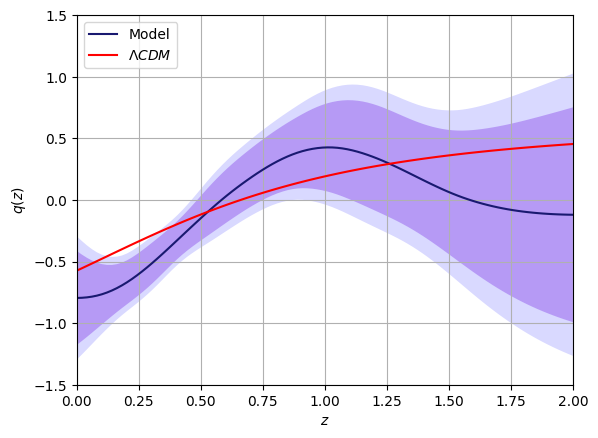

In [18]:
plt.xlim(0, 2)
plt.ylim(-1.5,1.5)

plt.plot(zx.ravel(), q, label=u'Model',color="midnightblue")
plt.fill_between(zx.ravel(), q + 1.96*sig_q, 
                     q - 1.96*sig_q, facecolor='blueviolet',alpha=0.35)
plt.fill_between(zx.ravel(), q + 2.576*sig_q, 
                     q - 2.576*sig_q, facecolor='blue',alpha=0.15)

q_lcdm=np.array([-(D_pp_lcdm(0.266,0,0.732,i)*H_lcdm(0.266,0,0.732,i)/H_0)*(1+i)-1 for i in zx.ravel()])
plt.plot(zx.ravel(),q_lcdm,color="red",label="$\Lambda CDM$")

plt.xlabel("$z$")
plt.ylabel("$q(z)$")
plt.legend(loc='upper left')
plt.grid()
plt.savefig("q_lcdm");

## Comparisons with LCDM mock data set

A mock data set for the deceleration parameter assuming $\Lambda CDM$ model as correct is created up next. Then, it is compared with the obtained model for $q(z)$ from gaussian processes.

In [19]:
z_mock=np.linspace(0,2.,30)

# LCDM mock data set
H_mock=np.array([H_lcdm(0.266,0,0.732,i) for i in z_mock])+10*np.random.uniform(-1,1,30)
sigma_H_mock=np.array([40*random.random() for i in H_mock])

In [20]:
Dp_mock=H_0/H_mock
sigma_Dp_mock=np.array([np.sqrt((H_0**2/H_mock[i]**2)*(sigma_H0**2/H_0**2 +
        sigma_H_mock[i]**2/H_mock[i]**2)) for i in range(len(H_mock))])

In [21]:
g = dgp.DGaussianProcess(z_mock, Dp_mock, sigma_Dp_mock, Xstar = [i for i in z_mock])

(drec, theta) = g.dgp(thetatrain = 'False')

D_pp=drec[:,1];sigma_Dpp=drec[:,2];
D_p=Dp_mock;sigma_Dp=sigma_Dp_mock;

In [22]:
zs_mock=np.atleast_2d(np.array([i for i in z_mock])).T;

q_mock=np.array([-(D_pp[i]/D_p[i])*(1+zs_mock[i][0])-1 for i in range(len(zs_mock))])

sig_quot_mock=np.array([np.sqrt(((D_pp[i]**2)/(D_p[i]**2))*((sigma_Dpp[i]**2)/(D_pp[i]**2) + 
                (sigma_Dp[i]**2)/(D_p[i]**2))) for i in range(len(D_p))])

sigma_q_mock=np.array([sig_quot_mock[i] + zs_mock[i][0]*sig_quot_mock[i] for i in range(len(sig_quot_mock))])

In [23]:
gp = GaussianProcessRegressor(kernel=k,alpha=sigma_q_mock**2,n_restarts_optimizer=10)

gp.fit(zs_mock, q_mock)

z_mock = np.atleast_2d(np.linspace(0, 2., 100)).T

q_mock,sig_q_mock=gp.predict(z_mock,return_std=True)

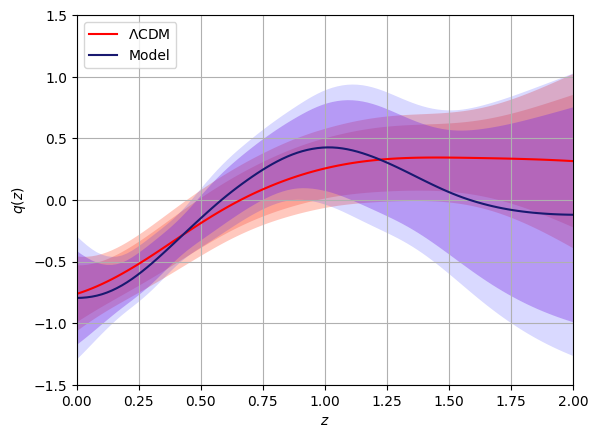

In [24]:
plt.xlim(0, 2)
plt.ylim(-1.5,1.5)

plt.plot(z_mock.ravel(), q_mock, label=u'$\Lambda$CDM',color="red")
plt.fill_between(z_mock.ravel(), q_mock + 1.96*sig_q_mock, 
                     q_mock - 1.96*sig_q_mock, facecolor='salmon',alpha=0.45)
plt.fill_between(z_mock.ravel(), q_mock + 2.576*sig_q_mock, 
                     q_mock - 2.576*sig_q_mock, facecolor='tomato',alpha=0.35)

plt.plot(zx.ravel(), q, label=u'Model',color="midnightblue")
plt.fill_between(zx.ravel(), q + 1.96*sig_q, 
                     q - 1.96*sig_q, facecolor='blueviolet',alpha=0.35)
plt.fill_between(zx.ravel(), q + 2.576*sig_q, 
                     q - 2.576*sig_q, facecolor='blue',alpha=0.15)

plt.xlabel("$z$")
plt.ylabel("$q(z)$")
plt.legend(loc='upper left')
plt.grid()
plt.savefig("lcdm_err");

It can be concluded that the predictions from gaussian processes regression and differentiation are considerably close to the values of the deceleration parameter obtained from $\Lambda CDM$. Even though the curves are not exactly on the same line, the confidence levels overlap along a large zone over the interval $[0,2]$.

Recall that the gaussian processes model was derived from observational data, which could indicate that $\Lambda CDM$ is a good approach to the real behaviour of $q(z)$.